In [1]:

import torch
import torch.optim as optim
import os
import math
import torch.nn as nn
import matplotlib.pyplot as plt
from utilz.utils import *
from models.encdec import *
import cv2
import numpy as np

tensor([[6.5900e-01, 2.4243e-01, 9.8566e-02],
        [3.0590e-07, 4.1399e-08, 1.0000e+00],
        [2.5950e-01, 7.0538e-01, 3.5119e-02]])


In [23]:
probs.max(1).indices

tensor([0, 2, 1])

In [2]:
input_size, hidden_size, num_layers, output_size, epochs, patience_limit,  learning_rate = 10, 512, 1, 2, 300, 20, 0.01
sl, sw , shift, batch_size = 20, 5, 20, 256
future = 20
ct = '05-17-18-00'
code = f"LR{int(learning_rate*1000)}_HS{hidden_size}_NL{num_layers}_BS{batch_size} {ct}"
cwd = os.getcwd()
csvpath = os.path.join(cwd,'Processed','Trj20240510T1529.csv')

In [3]:
# Load the train loader data
# train_loader = torch.load(os.path.join(os.getcwd(),'Pickled','train_loader.pt'))
# test_loader = torch.load(os.path.join(os.getcwd(),'Pickled','test_loader.pt'))
model = torch.load(os.path.join(os.getcwd(),'Processed', code + 'Bestmodel.pth'))

In [4]:
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     savelog(f"Using {torch.cuda.device_count()} GPUs", ct)
#     model = nn.DataParallel(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate )

In [5]:

df = loadcsv(csvpath)
dataset= def_class(df, sw, sl, shift, future, input_size, output_size, tr2img= False, ct= ct, imgsize=1024, Dsample = 4, normalize = False, device = device)
train_loader, test_loader, val_loader = prep_data(dataset, batch_size, ct, seed = True) #seed must always be true

normalizing trajectory data
dataset saved
Train size: 17438, Test size: 1937, Validation size: 1 
Using seed for random split


In [6]:
Predicteddata, target, ego, avg_test_loss, accuracy, log = test_model(model, test_loader, future, output_size, device, criterion)

In [12]:
target_list = []
scene_list = []
ego_list = []
for egoz, scenez, trfl, targetz in test_loader:
    for i in range(egoz.size(0)):
        ego_list.append(egoz[i])
        target_list.append(targetz[i])
        scene_list.append(scenez[i])

In [ ]:
# print(Predicteddata[i])
i = 90
print(target_list[i], scene_list[i])

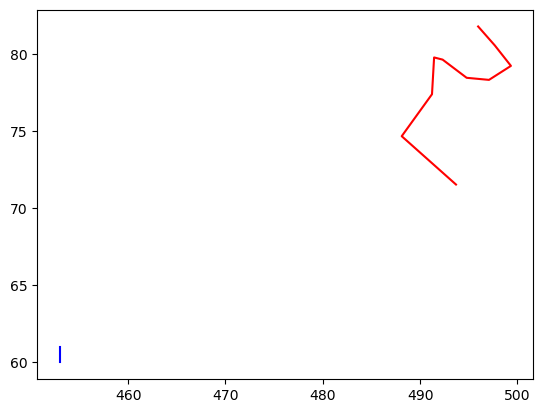

In [24]:
i = 460
plt.plot(Predicteddata[i,:,0].to('cpu'), Predicteddata[i,:,1].to('cpu'), 'r')
plt.plot(target_list[i][:,0].to('cpu'), target_list[i][:,1].to('cpu'), 'b')


In [7]:
import yaml

import re
ZoneConf = []
with open('utilz/ZoneConf.yaml') as file:
    ZonesYML = yaml.load(file, Loader=yaml.FullLoader)
    #convert the string values to float
    for _, v in ZonesYML.items():
        lst = []
        for _, p  in v.items():    
            for x in p[0]:
                b = re.split(r'[,()]',p[0][x])
                lst.append((float(b[1]), float(b[2])))
        ZoneConf.append(lst)
from shapely.geometry import Point, Polygon
def zonefinder(BBx,BBy, Zones):
    for i, zone in enumerate(Zones):
        Poly = Polygon(zone)
        if Poly.contains(Point(BBx, BBy)):
            return i
    return 100

def Move(zn):
    movement = np.zeros((5,1))
    i = 0
    for n, inx in enumerate(zn[1:]):
        if inx != zn[n]:
            movement[inx] = 1
            movement[zn[n]] = 1
            i += 1
            print("moved")
    return i

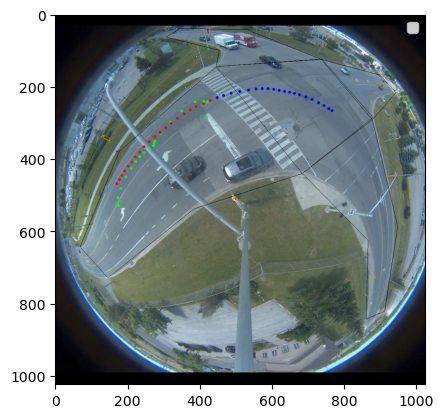

In [18]:
# load an image and plot the ego and target on the image

green = (0,255,0)
red = (0,0,255)
blue = (255,0,0)

i = 369
pred = Predicteddata[i,:,:].to('cpu').numpy()
grth = ego[i]
grth_target = target[i]
img = cv2.imread('RawData/16.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# add points to the coordinates on pred, grth and grth_target
for i in range(len(pred)):
    cv2.circle(img, (int(pred[i,0]), int(pred[i,1])), 4, green, -1)
    cv2.circle(img, (int(grth[i,0]), int(grth[i,1])), 4, red, -1)
    cv2.circle(img, (int(grth_target[i,0]), int(grth_target[i,1])), 4, blue, -1)

#plot polygon on the image
for i, zone in enumerate(ZoneConf):
    cv2.polylines(img, [np.array(zone).astype(np.int32)], isClosed=True, color=(0,0,0), thickness=1)
plt.imshow(img)
plt.legend(['Predicted', 'Ego', 'Target'])